# P03 银行营销预测 - 分类模型实战

## 学习目标

1. 理解二分类问题的完整建模流程
2. 掌握逻辑回归和决策树算法
3. 学习特征工程：标准化、编码
4. 掌握模型评估：准确率、精确率、召回率、F1、AUC-ROC
5. 理解类别不平衡问题及处理方法

## 业务场景

**问题**: 银行通过电话营销推广定期存款产品，如何预测客户是否会订购？

**数据**: 葡萄牙银行真实营销数据（UCI Repository）
- 45,211条记录
- 17个特征（客户信息、账户信息、营销活动信息）
- 目标：是否订购定期存款（yes/no）

**价值**: 
- 提高营销效率：优先联系高概率客户
- 降低成本：减少无效电话
- 提升客户体验：避免过度骚扰

## 1. 环境准备

In [1]:
# 导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report, ConfusionMatrixDisplay
)

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS
# plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows/Linux
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("环境准备完成!")

环境准备完成!


## 2. 数据加载与探索

In [2]:
# 加载数据
df = pd.read_csv('../../../../data/stage3/bank_marketing.csv')

print(f"数据shape: {df.shape}")
print(f"\n前5行:")
df.head()

数据shape: (45211, 17)

前5行:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# 数据基本信息
print("数据类型:")
print(df.dtypes)
print("\n缺失值:")
print(df.isnull().sum())
print("\n数值特征统计:")
df.describe()

数据类型:
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

缺失值:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

数值特征统计:


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


目标变量分布:
y
no     39922
yes     5289
Name: count, dtype: int64

正样本比例: 11.70%
负样本比例: 88.30%
类别不平衡比: 1:7.5


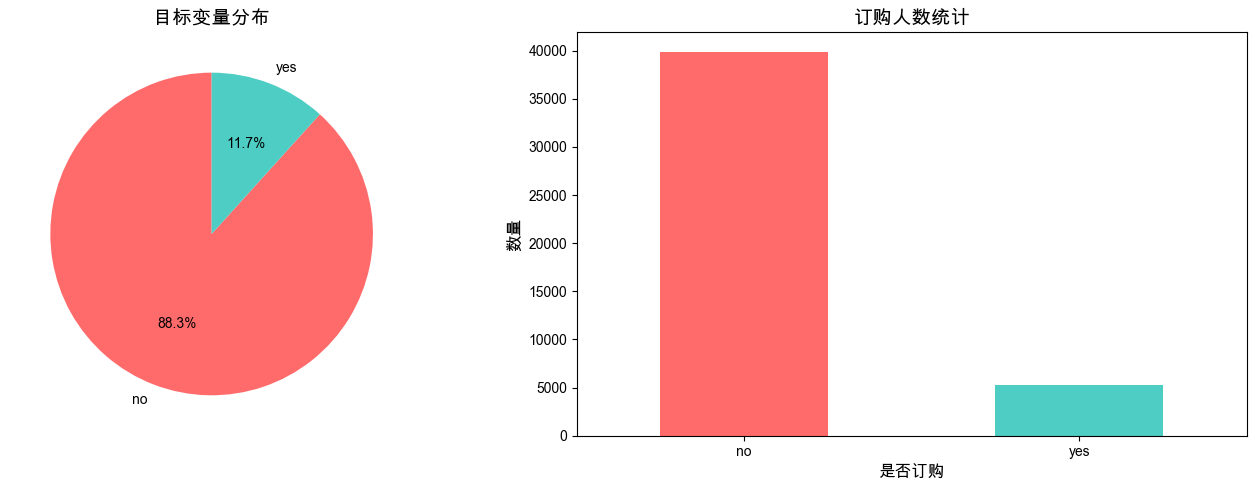


⚠️ 注意：类别严重不平衡（正样本仅11.7%），需要特殊处理！


In [4]:
# 目标变量分布
target_counts = df['y'].value_counts()
print("目标变量分布:")
print(target_counts)
print(f"\n正样本比例: {target_counts['yes'] / len(df) * 100:.2f}%")
print(f"负样本比例: {target_counts['no'] / len(df) * 100:.2f}%")
print(f"类别不平衡比: 1:{target_counts['no'] / target_counts['yes']:.1f}")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 饼图
axes[0].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
           colors=['#FF6B6B', '#4ECDC4'], startangle=90)
axes[0].set_title('目标变量分布', fontsize=14)

# 柱状图
target_counts.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4'])
axes[1].set_title('订购人数统计', fontsize=14)
axes[1].set_xlabel('是否订购', fontsize=12)
axes[1].set_ylabel('数量', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\n⚠️ 注意：类别严重不平衡（正样本仅11.7%），需要特殊处理！")

## 3. 探索性数据分析 (EDA)

### 3.1 数值特征分布

数值特征: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


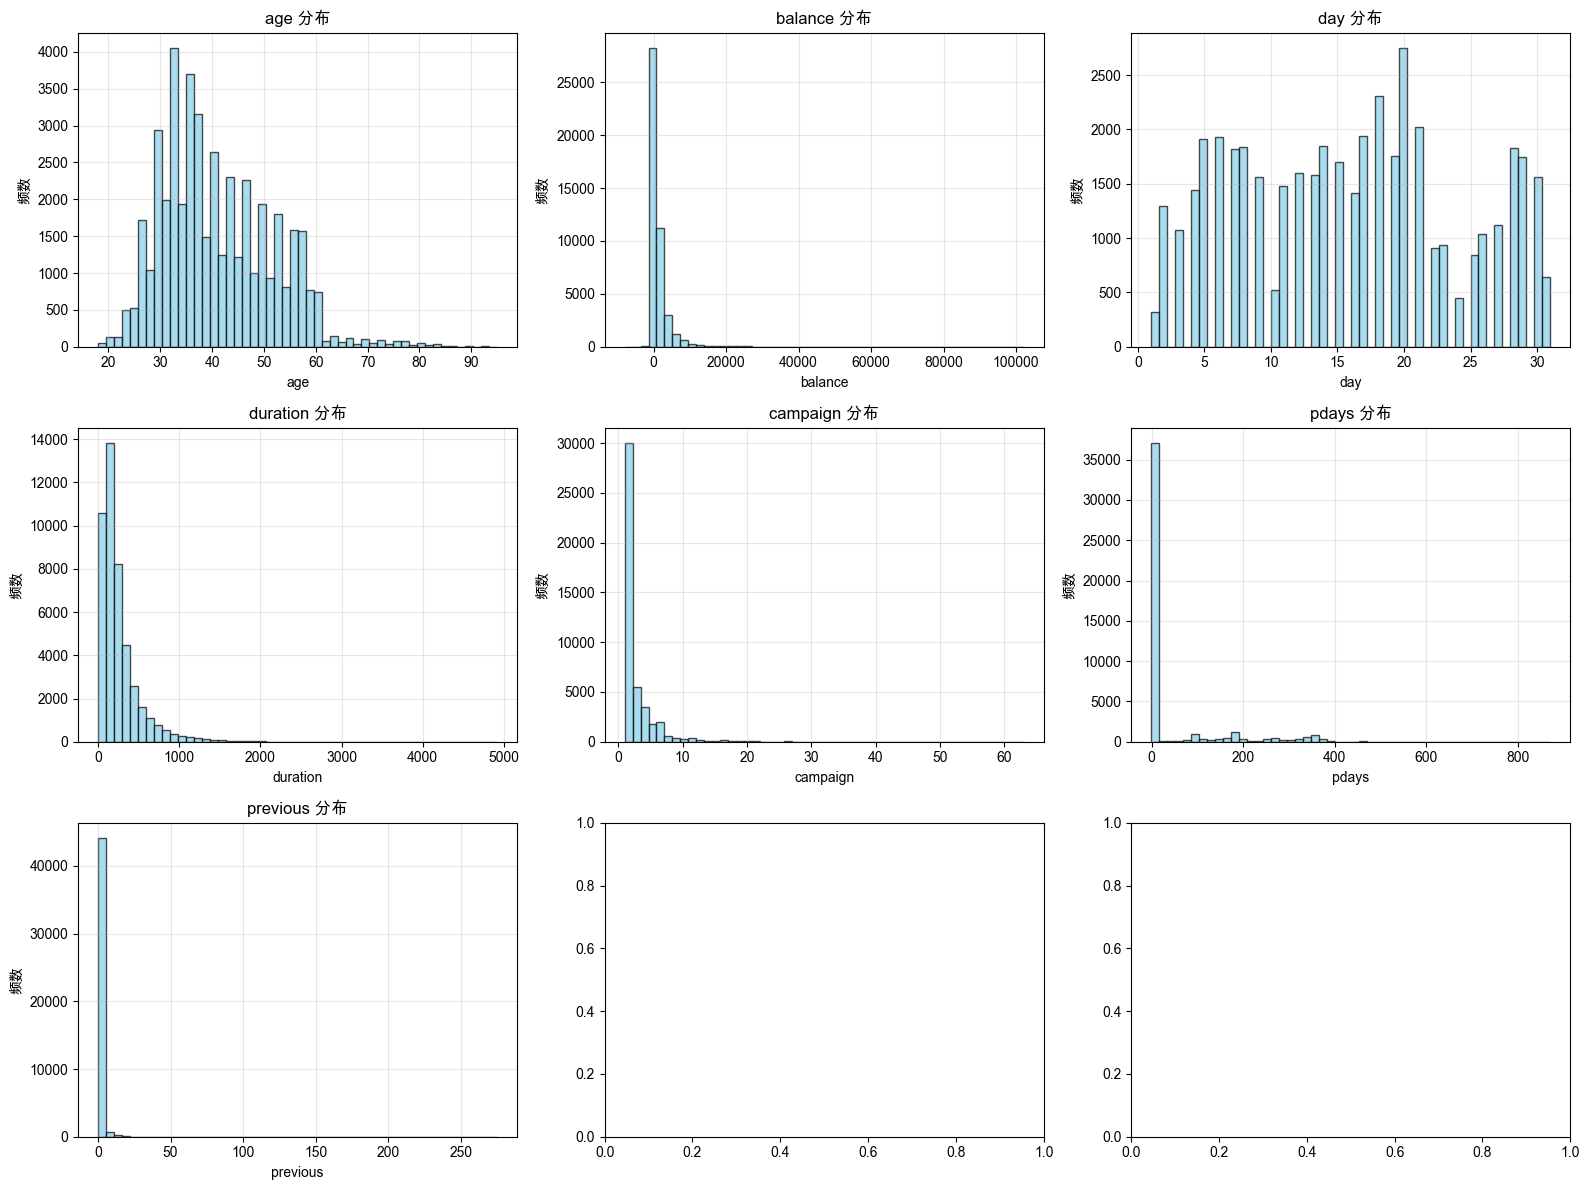

In [5]:
# 数值特征
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"数值特征: {numeric_features}")

# 可视化分布
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_features):
    axes[idx].hist(df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} 分布', fontsize=12)
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('频数', fontsize=10)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 类别特征分布

类别特征: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


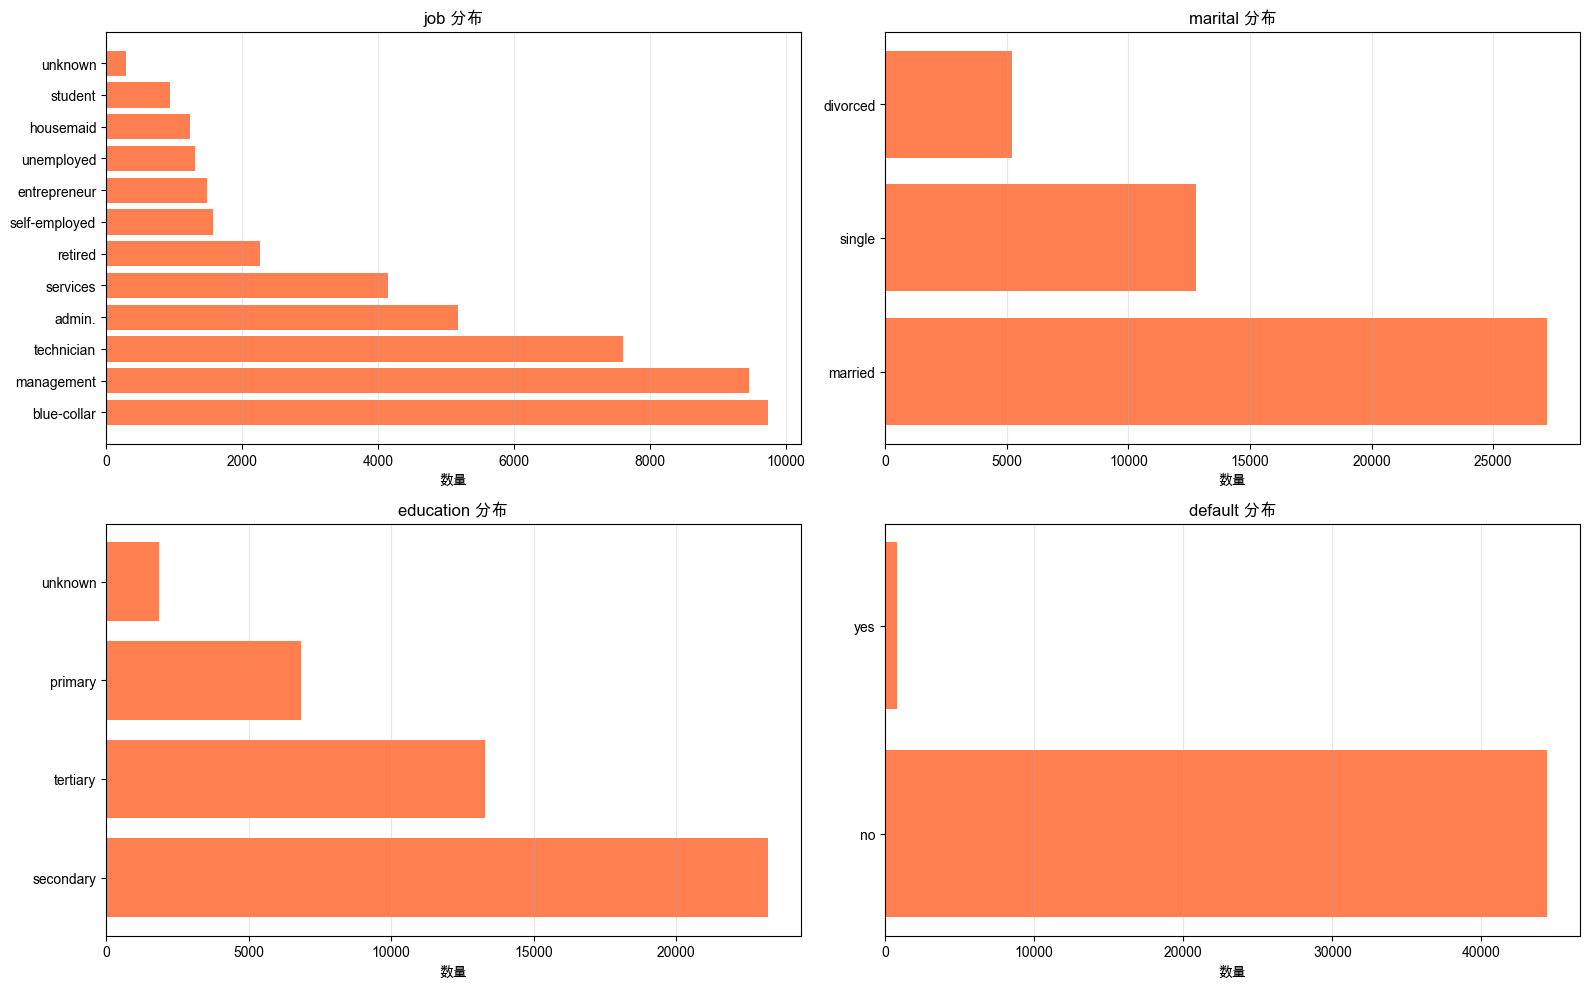

In [6]:
# 类别特征
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('y')  # 移除目标变量
print(f"类别特征: {categorical_features}")

# 可视化前4个类别特征
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_features[:4]):
    value_counts = df[col].value_counts()
    axes[idx].barh(range(len(value_counts)), value_counts.values, color='coral')
    axes[idx].set_yticks(range(len(value_counts)))
    axes[idx].set_yticklabels(value_counts.index)
    axes[idx].set_title(f'{col} 分布', fontsize=12)
    axes[idx].set_xlabel('数量', fontsize=10)
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 特征与目标的关系

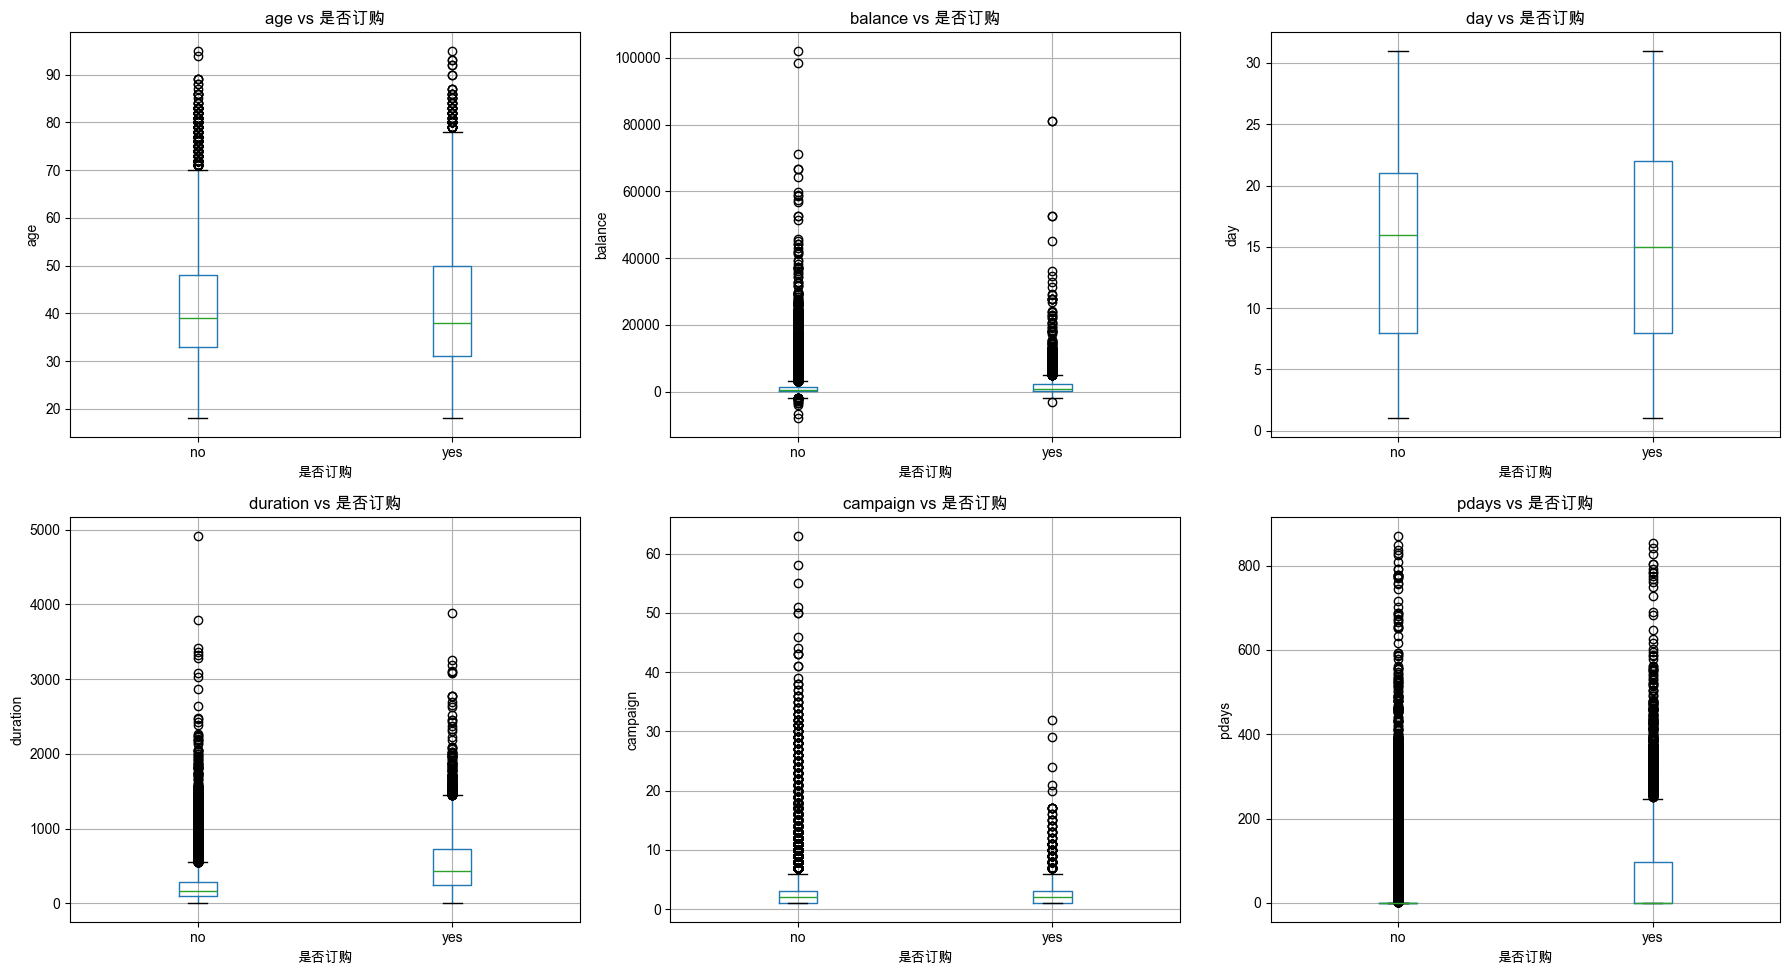

In [7]:
# 数值特征与目标的关系
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_features[:6]):
    df.boxplot(column=col, by='y', ax=axes[idx])
    axes[idx].set_title(f'{col} vs 是否订购', fontsize=12)
    axes[idx].set_xlabel('是否订购', fontsize=10)
    axes[idx].set_ylabel(col, fontsize=10)

plt.suptitle('')  # 移除默认标题
plt.tight_layout()
plt.show()

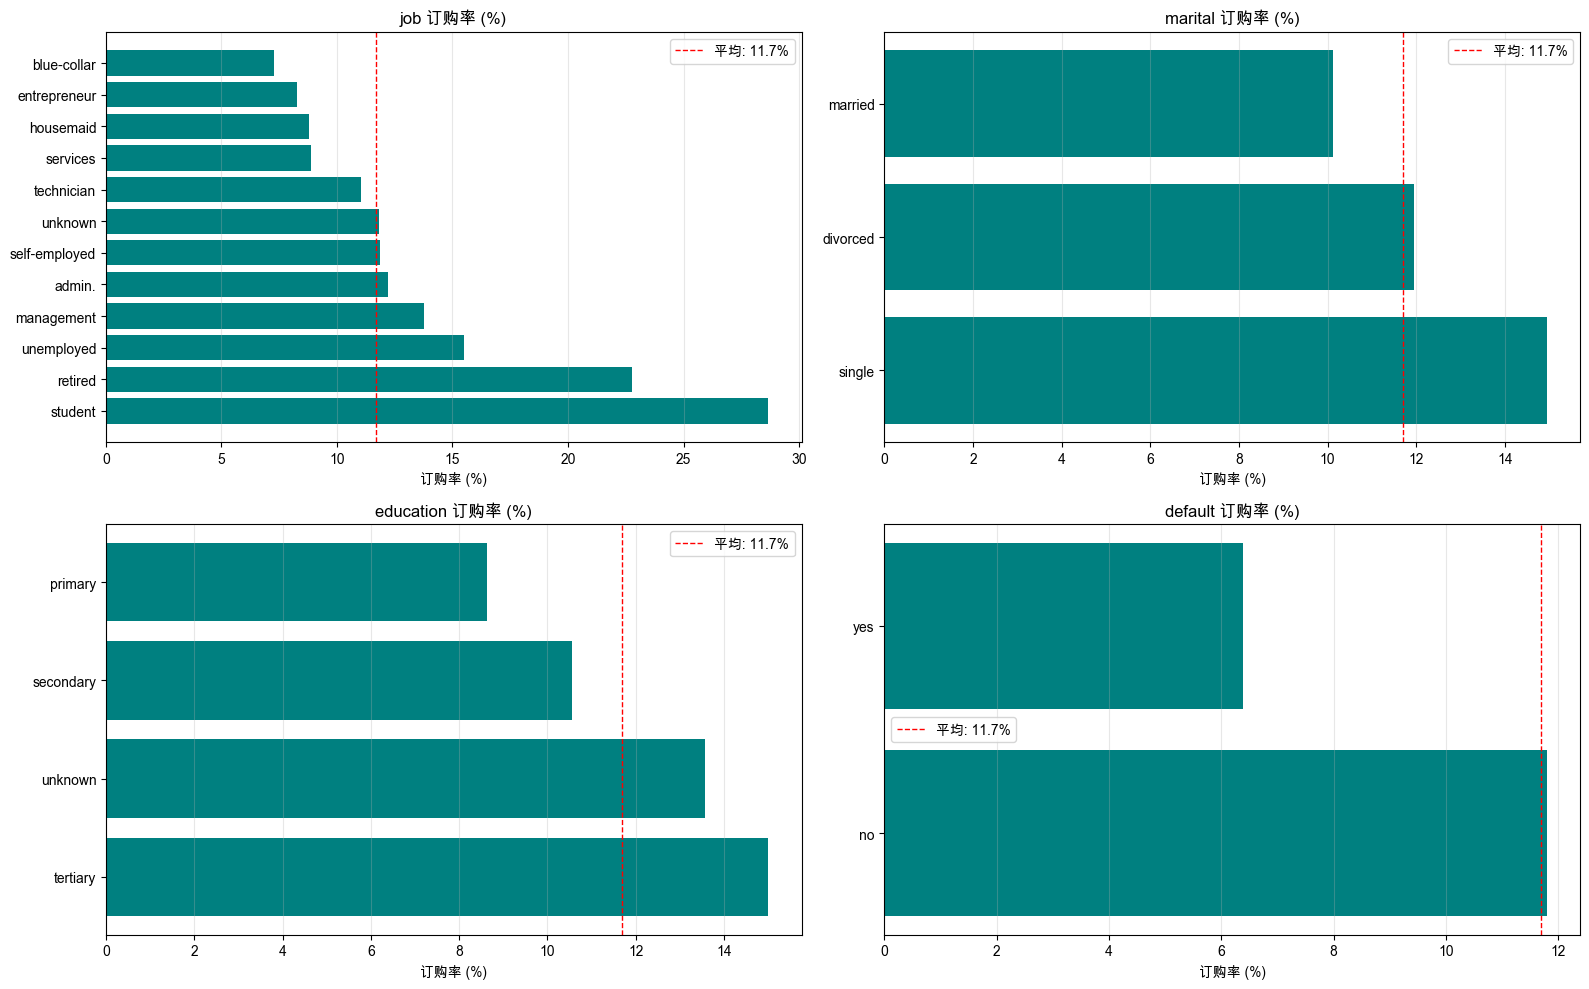

In [8]:
# 类别特征与目标的关系 - 订购率对比
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_features[:4]):
    # 计算每个类别的订购率
    subscription_rate = df.groupby(col)['y'].apply(lambda x: (x == 'yes').sum() / len(x) * 100)
    subscription_rate = subscription_rate.sort_values(ascending=False)
    
    axes[idx].barh(range(len(subscription_rate)), subscription_rate.values, color='teal')
    axes[idx].set_yticks(range(len(subscription_rate)))
    axes[idx].set_yticklabels(subscription_rate.index)
    axes[idx].set_title(f'{col} 订购率 (%)', fontsize=12)
    axes[idx].set_xlabel('订购率 (%)', fontsize=10)
    axes[idx].grid(axis='x', alpha=0.3)
    
    # 添加平均线
    avg_rate = (df['y'] == 'yes').sum() / len(df) * 100
    axes[idx].axvline(x=avg_rate, color='red', linestyle='--', linewidth=1, label=f'平均: {avg_rate:.1f}%')
    axes[idx].legend()

plt.tight_layout()
plt.show()

### 3.4 相关性分析

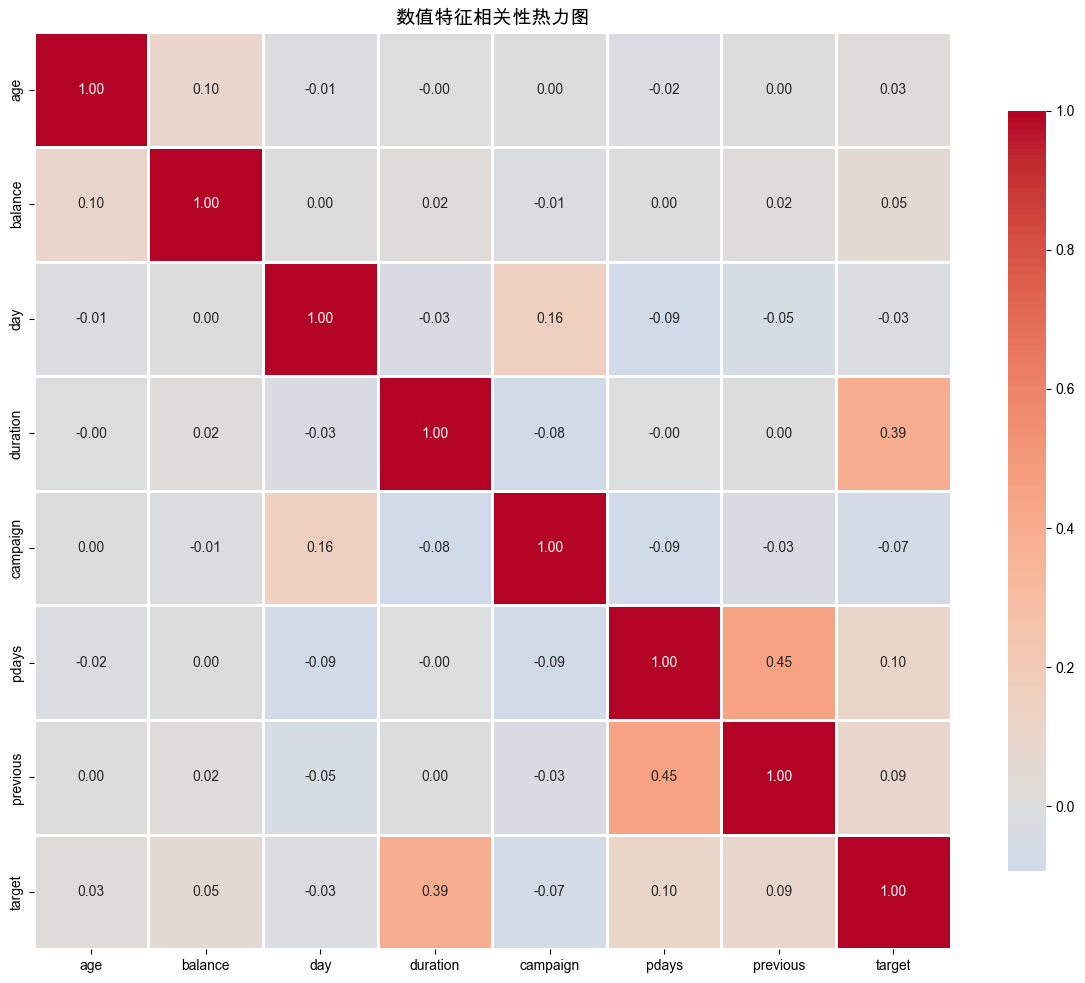


与目标相关性最强的特征:
duration    0.394521
pdays       0.103621
previous    0.093236
campaign   -0.073172
balance     0.052838
Name: target, dtype: float64


In [9]:
# 计算数值特征相关性
numeric_df = df[numeric_features].copy()
numeric_df['target'] = (df['y'] == 'yes').astype(int)

plt.figure(figsize=(12, 10))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('数值特征相关性热力图', fontsize=14)
plt.tight_layout()
plt.show()

# 与目标相关性最强的特征
target_corr = corr_matrix['target'].drop('target').sort_values(key=abs, ascending=False)
print("\n与目标相关性最强的特征:")
print(target_corr.head(5))

## 4. 数据预处理

### 4.1 移除duration特征

⚠️ **重要**: `duration`是最后通话时长，只有通话结束后才知道。实际预测时不可用，使用它会导致**数据泄漏**！

In [10]:
# 移除duration
df_clean = df.drop(columns=['duration']).copy()
print(f"移除duration后特征数: {df_clean.shape[1] - 1}")  # -1是目标变量

移除duration后特征数: 15


### 4.2 分离特征和目标

In [11]:
# 分离X和y
X = df_clean.drop(columns=['y'])
y = df_clean['y'].map({'yes': 1, 'no': 0})

print(f"特征矩阵 X: {X.shape}")
print(f"目标变量 y: {y.shape}")
print(f"\n正样本数: {y.sum()}, 负样本数: {len(y) - y.sum()}")

特征矩阵 X: (45211, 15)
目标变量 y: (45211,)

正样本数: 5289, 负样本数: 39922


### 4.3 划分训练测试集

In [12]:
# 划分数据集 (stratify保持类别比例)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"训练集大小: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"测试集大小: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n训练集正样本比例: {y_train.sum() / len(y_train) * 100:.2f}%")
print(f"测试集正样本比例: {y_test.sum() / len(y_test) * 100:.2f}%")

训练集大小: 36168 (80.0%)
测试集大小: 9043 (20.0%)

训练集正样本比例: 11.70%
测试集正样本比例: 11.70%


### 4.4 特征工程

#### 4.4.1 独热编码 (One-Hot Encoding)

In [13]:
# 识别类别特征
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"类别特征: {categorical_cols}")

# 独热编码 (drop_first=True避免多重共线性)
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# 确保训练集和测试集有相同的列
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(f"\n编码后特征数: {X_train_encoded.shape[1]}")
print(f"新增特征: {X_train_encoded.shape[1] - X_train.shape[1]}")

类别特征: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

编码后特征数: 41
新增特征: 26


#### 4.4.2 标准化 (Standardization)

In [14]:
# 标准化 (转换为均值=0, 标准差=1)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_encoded),
    columns=X_test_encoded.columns,
    index=X_test_encoded.index
)

print("标准化完成!")
print(f"\n标准化前 - age均值: {X_train_encoded['age'].mean():.2f}, 标准差: {X_train_encoded['age'].std():.2f}")
print(f"标准化后 - age均值: {X_train_scaled['age'].mean():.2f}, 标准差: {X_train_scaled['age'].std():.2f}")

标准化完成!

标准化前 - age均值: 40.89, 标准差: 10.63
标准化后 - age均值: -0.00, 标准差: 1.00


## 5. 模型训练

### 5.1 逻辑回归 (Logistic Regression)

**原理**: 线性模型 + Sigmoid激活函数

$$P(y=1|x) = \frac{1}{1 + e^{-(w_0 + w_1x_1 + ... + w_nx_n)}}$$

**优点**: 简单、快速、输出概率、易解释

**缺点**: 假设线性关系，对非线性数据效果差

In [15]:
# 训练逻辑回归 (class_weight='balanced'处理类别不平衡)
lr = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=RANDOM_STATE
)

lr.fit(X_train_scaled, y_train)
print("逻辑回归训练完成!")

# 交叉验证
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\n5折交叉验证 AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

逻辑回归训练完成!

5折交叉验证 AUC: 0.7640 (+/- 0.0065)


### 5.2 决策树 (Decision Tree)

**原理**: 递归划分特征空间，构建树形结构

**划分标准**: 基尼指数 (Gini) 或 信息增益 (Entropy)

**优点**: 捕捉非线性关系、自动特征选择、易可视化

**缺点**: 容易过拟合、对噪声敏感

In [16]:
# 训练决策树 (限制深度防止过拟合)
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

dt.fit(X_train_scaled, y_train)
print("决策树训练完成!")

# 交叉验证
cv_scores = cross_val_score(dt, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\n5折交叉验证 AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

决策树训练完成!

5折交叉验证 AUC: 0.7627 (+/- 0.0108)


## 6. 模型评估

### 6.1 评估指标说明

- **准确率 (Accuracy)**: (TP+TN) / 总数 - 适合类别平衡数据
- **精确率 (Precision)**: TP / (TP+FP) - 预测为正的准确性，业务含义是营销成功率
- **召回率 (Recall)**: TP / (TP+FN) - 实际为正的覆盖率，业务含义是潜在客户覆盖率
- **F1分数**: 精确率和召回率的调和平均 - 适合类别不平衡数据
- **AUC-ROC**: ROC曲线下面积 - 衡量模型排序能力

### 6.2 逻辑回归评估

In [17]:
# 预测
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# 计算指标
print("逻辑回归评估结果:")
print(f"准确率 (Accuracy):  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"精确率 (Precision): {precision_score(y_test, y_pred_lr):.4f}")
print(f"召回率 (Recall):    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1分数 (F1-Score):  {f1_score(y_test, y_pred_lr):.4f}")
print(f"AUC-ROC:            {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# 详细报告
print("\n分类报告:")
print(classification_report(y_test, y_pred_lr, target_names=['No', 'Yes']))

逻辑回归评估结果:
准确率 (Accuracy):  0.7557
精确率 (Precision): 0.2669
召回率 (Recall):    0.6229
F1分数 (F1-Score):  0.3737
AUC-ROC:            0.7722

分类报告:
              precision    recall  f1-score   support

          No       0.94      0.77      0.85      7985
         Yes       0.27      0.62      0.37      1058

    accuracy                           0.76      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.76      0.79      9043



### 6.3 决策树评估

In [18]:
# 预测
y_pred_dt = dt.predict(X_test_scaled)
y_pred_proba_dt = dt.predict_proba(X_test_scaled)[:, 1]

# 计算指标
print("决策树评估结果:")
print(f"准确率 (Accuracy):  {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"精确率 (Precision): {precision_score(y_test, y_pred_dt):.4f}")
print(f"召回率 (Recall):    {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1分数 (F1-Score):  {f1_score(y_test, y_pred_dt):.4f}")
print(f"AUC-ROC:            {roc_auc_score(y_test, y_pred_proba_dt):.4f}")

# 详细报告
print("\n分类报告:")
print(classification_report(y_test, y_pred_dt, target_names=['No', 'Yes']))

决策树评估结果:
准确率 (Accuracy):  0.8199
精确率 (Precision): 0.3382
召回率 (Recall):    0.5643
F1分数 (F1-Score):  0.4230
AUC-ROC:            0.7630

分类报告:
              precision    recall  f1-score   support

          No       0.94      0.85      0.89      7985
         Yes       0.34      0.56      0.42      1058

    accuracy                           0.82      9043
   macro avg       0.64      0.71      0.66      9043
weighted avg       0.87      0.82      0.84      9043



### 6.4 混淆矩阵

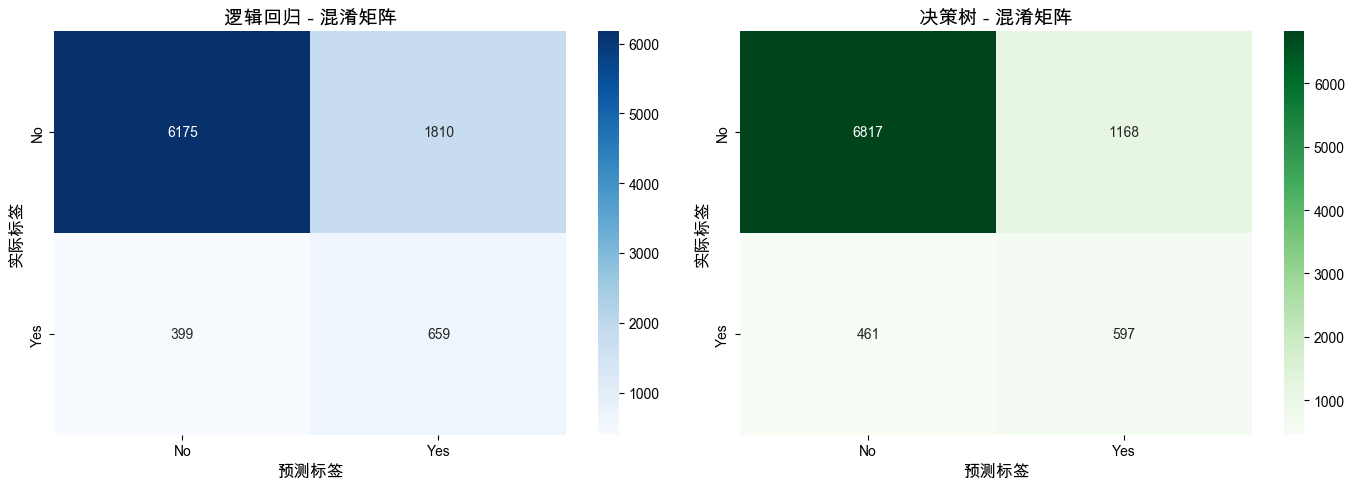


混淆矩阵解读:
逻辑回归 - TN: 6175, FP: 1810, FN: 399, TP: 659
决策树   - TN: 6817, FP: 1168, FN: 461, TP: 597


In [19]:
# 绘制混淆矩阵
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 逻辑回归
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0].set_title('逻辑回归 - 混淆矩阵', fontsize=14)
axes[0].set_ylabel('实际标签', fontsize=12)
axes[0].set_xlabel('预测标签', fontsize=12)

# 决策树
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
           xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[1].set_title('决策树 - 混淆矩阵', fontsize=14)
axes[1].set_ylabel('实际标签', fontsize=12)
axes[1].set_xlabel('预测标签', fontsize=12)

plt.tight_layout()
plt.show()

print("\n混淆矩阵解读:")
print(f"逻辑回归 - TN: {cm_lr[0,0]}, FP: {cm_lr[0,1]}, FN: {cm_lr[1,0]}, TP: {cm_lr[1,1]}")
print(f"决策树   - TN: {cm_dt[0,0]}, FP: {cm_dt[0,1]}, FN: {cm_dt[1,0]}, TP: {cm_dt[1,1]}")

### 6.5 ROC曲线

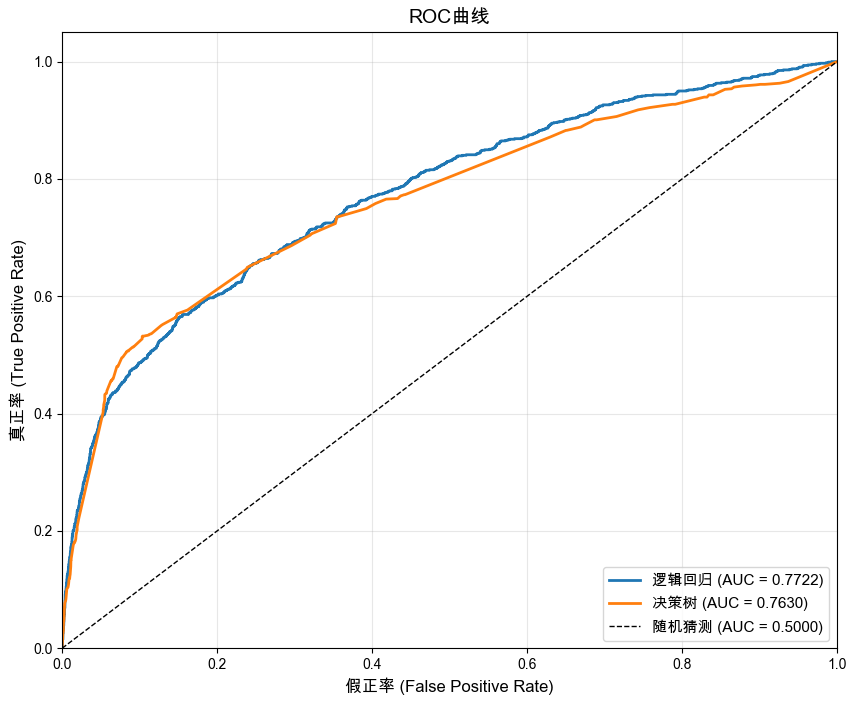


ROC-AUC解读:
- AUC = 0.5: 随机猜测
- 0.5 < AUC < 0.7: 效果较差
- 0.7 ≤ AUC < 0.8: 效果一般
- 0.8 ≤ AUC < 0.9: 效果良好
- AUC ≥ 0.9: 效果优秀


In [20]:
# 计算ROC曲线
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)

auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

# 绘制ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'逻辑回归 (AUC = {auc_lr:.4f})', linewidth=2)
plt.plot(fpr_dt, tpr_dt, label=f'决策树 (AUC = {auc_dt:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='随机猜测 (AUC = 0.5000)', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率 (False Positive Rate)', fontsize=12)
plt.ylabel('真正率 (True Positive Rate)', fontsize=12)
plt.title('ROC曲线', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.show()

print("\nROC-AUC解读:")
print("- AUC = 0.5: 随机猜测")
print("- 0.5 < AUC < 0.7: 效果较差")
print("- 0.7 ≤ AUC < 0.8: 效果一般")
print("- 0.8 ≤ AUC < 0.9: 效果良好")
print("- AUC ≥ 0.9: 效果优秀")

## 7. 特征重要性分析

### 7.1 逻辑回归特征系数

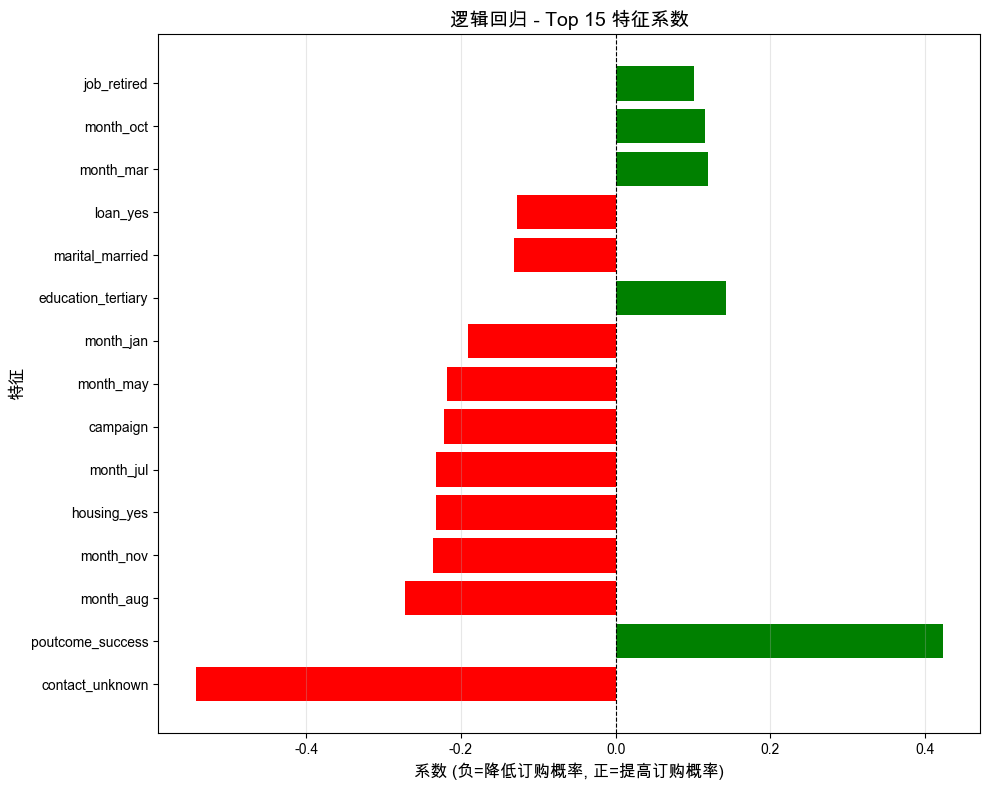


特征系数解读:
- 正系数: 该特征增加会提高订购概率
- 负系数: 该特征增加会降低订购概率
- 系数绝对值越大,影响越大


In [21]:
# 获取特征系数
feature_coef = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': lr.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False).head(15)

# 可视化
plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in feature_coef['coefficient']]
plt.barh(range(len(feature_coef)), feature_coef['coefficient'], color=colors)
plt.yticks(range(len(feature_coef)), feature_coef['feature'])
plt.xlabel('系数 (负=降低订购概率, 正=提高订购概率)', fontsize=12)
plt.ylabel('特征', fontsize=12)
plt.title('逻辑回归 - Top 15 特征系数', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n特征系数解读:")
print("- 正系数: 该特征增加会提高订购概率")
print("- 负系数: 该特征增加会降低订购概率")
print("- 系数绝对值越大,影响越大")

### 7.2 决策树特征重要性

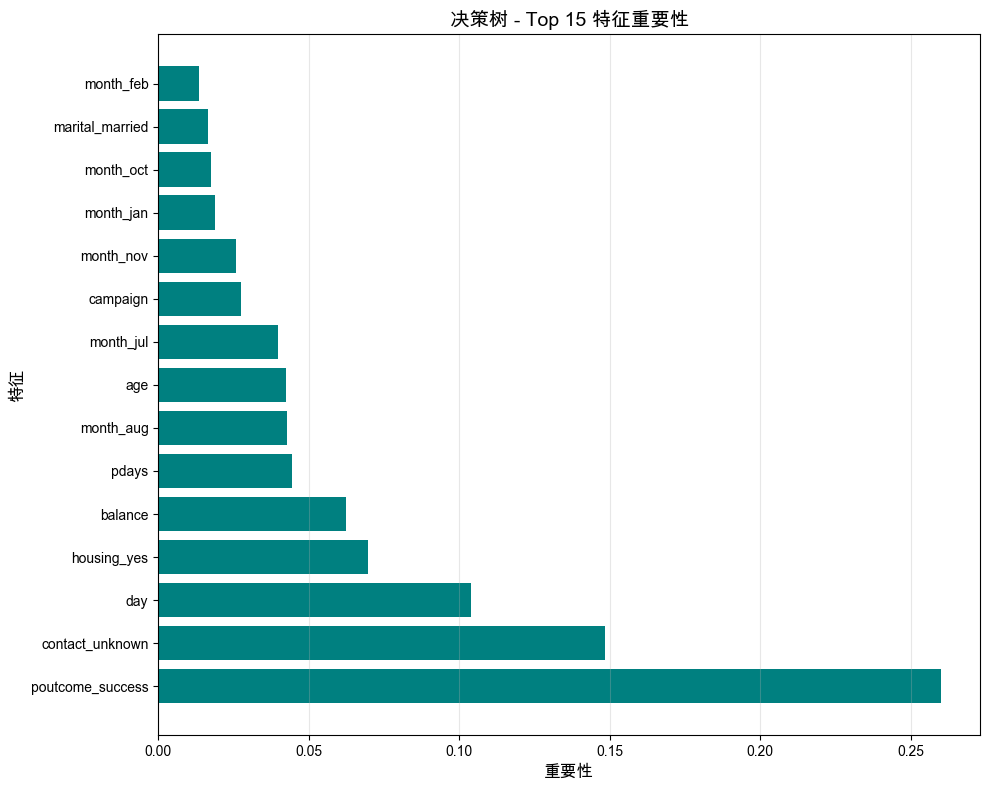


特征重要性解读:
- 值越大,特征对分类的贡献越大
- 基于基尼指数或信息增益计算
- 可用于特征选择


In [22]:
# 获取特征重要性
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False).head(15)

# 可视化
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='teal')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('重要性', fontsize=12)
plt.ylabel('特征', fontsize=12)
plt.title('决策树 - Top 15 特征重要性', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n特征重要性解读:")
print("- 值越大,特征对分类的贡献越大")
print("- 基于基尼指数或信息增益计算")
print("- 可用于特征选择")

### 7.3 决策树可视化

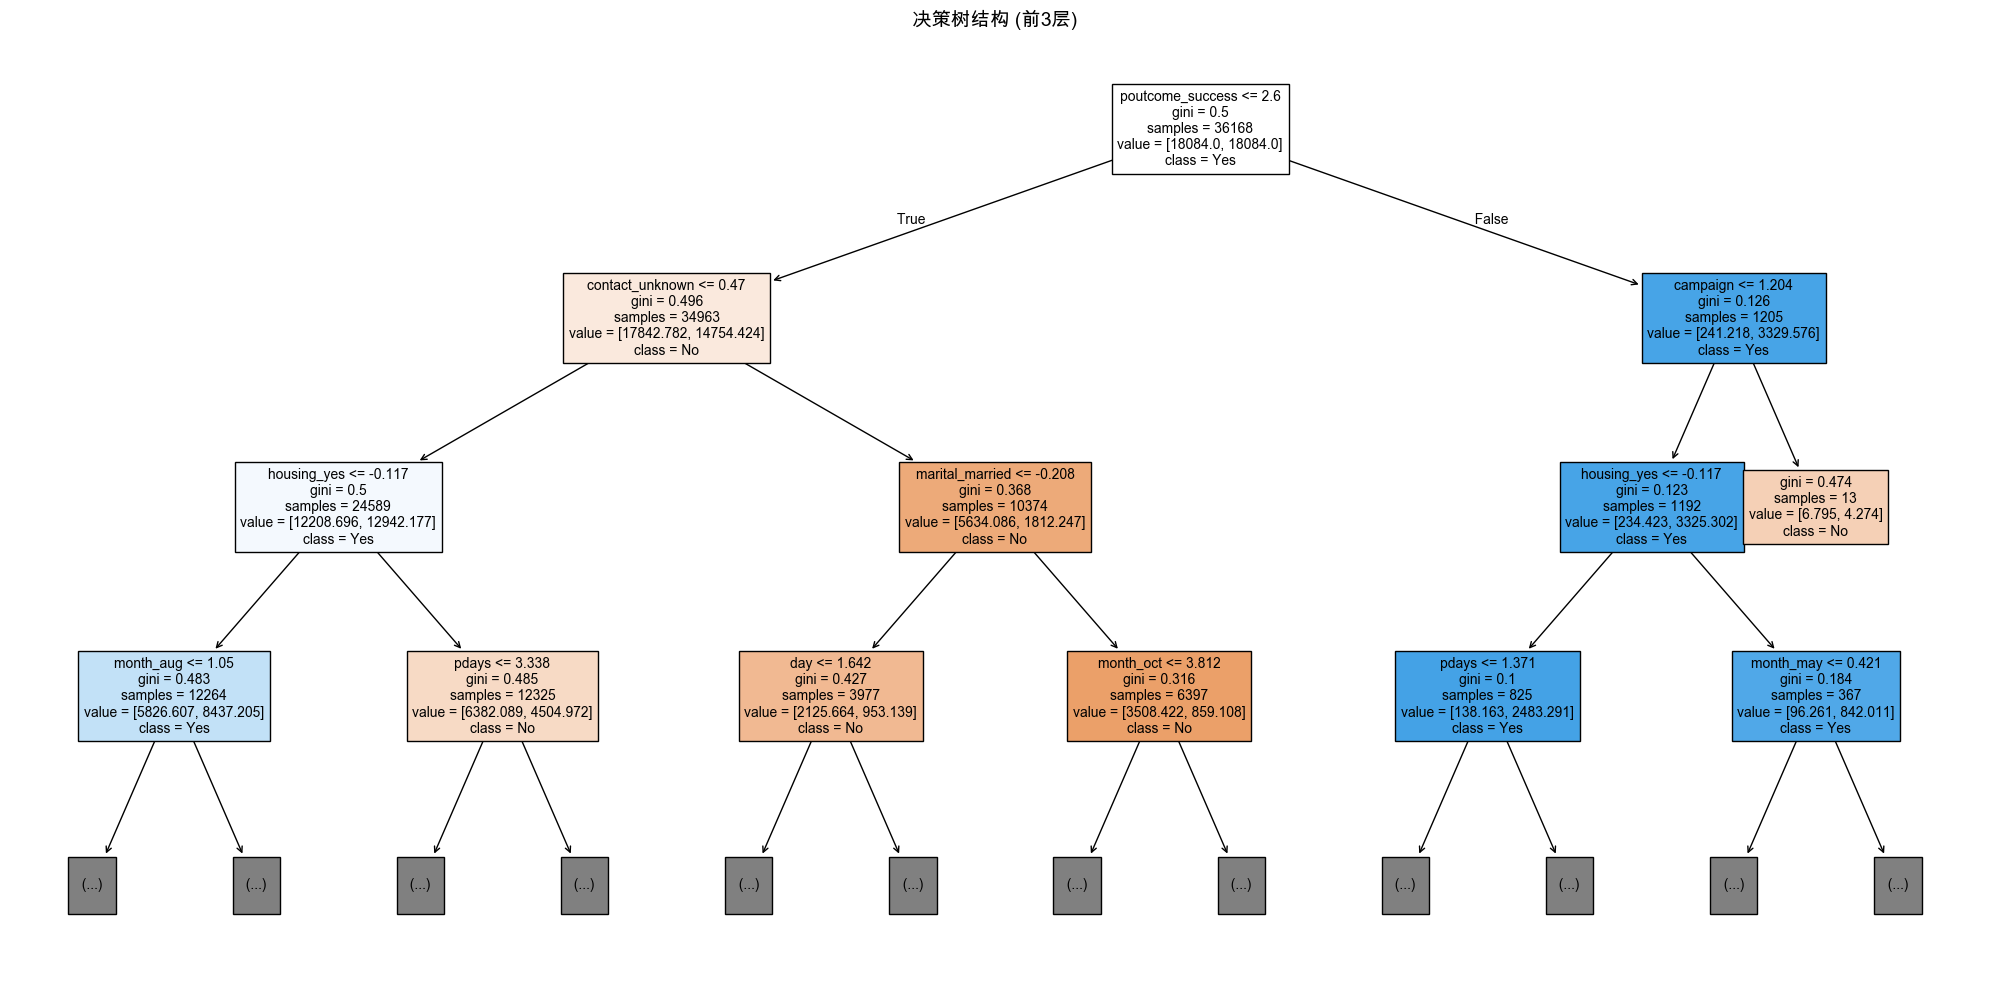


决策树解读:
- 每个节点显示划分条件
- gini: 基尼不纯度 (越小越纯)
- samples: 样本数量
- value: [负样本数, 正样本数]
- class: 多数类


In [23]:
# 绘制决策树 (只显示前3层)
plt.figure(figsize=(20, 10))
plot_tree(dt, max_depth=3, feature_names=X_train_scaled.columns,
         class_names=['No', 'Yes'], filled=True, fontsize=10)
plt.title('决策树结构 (前3层)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n决策树解读:")
print("- 每个节点显示划分条件")
print("- gini: 基尼不纯度 (越小越纯)")
print("- samples: 样本数量")
print("- value: [负样本数, 正样本数]")
print("- class: 多数类")

## 8. 模型比较与选择


模型性能对比:
  模型      准确率      精确率      召回率     F1分数  AUC-ROC
逻辑回归 0.755723 0.266910 0.622873 0.373689 0.772179
 决策树 0.819861 0.338244 0.564272 0.422954 0.763048


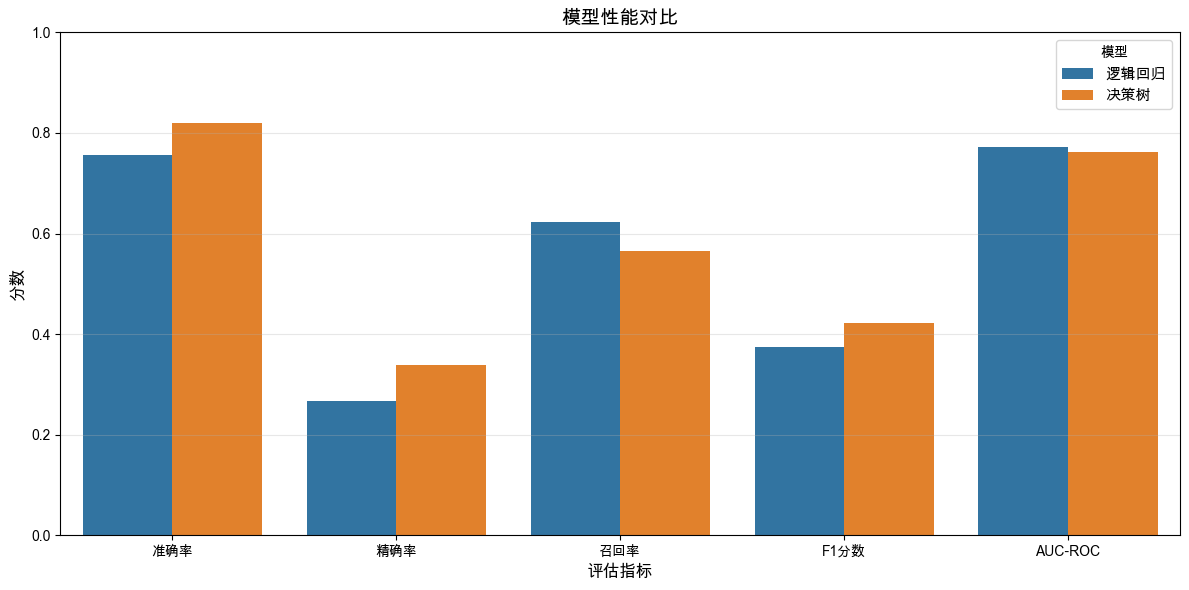


模型选择建议:
- 如果追求整体性能(AUC): 选择AUC更高的模型
- 如果追求营销成功率: 选择精确率更高的模型
- 如果追求客户覆盖率: 选择召回率更高的模型
- 如果平衡两者: 选择F1分数更高的模型


In [24]:
# 汇总对比
comparison = pd.DataFrame({
    '模型': ['逻辑回归', '决策树'],
    '准确率': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt)
    ],
    '精确率': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_dt)
    ],
    '召回率': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_dt)
    ],
    'F1分数': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_dt)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_dt)
    ]
})

print("\n模型性能对比:")
print(comparison.to_string(index=False))

# 可视化对比
comparison_melted = comparison.melt(id_vars='模型', var_name='指标', value_name='分数')
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x='指标', y='分数', hue='模型')
plt.title('模型性能对比', fontsize=14)
plt.ylabel('分数', fontsize=12)
plt.xlabel('评估指标', fontsize=12)
plt.ylim([0, 1])
plt.legend(title='模型', fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n模型选择建议:")
print("- 如果追求整体性能(AUC): 选择AUC更高的模型")
print("- 如果追求营销成功率: 选择精确率更高的模型")
print("- 如果追求客户覆盖率: 选择召回率更高的模型")
print("- 如果平衡两者: 选择F1分数更高的模型")

## 9. 业务应用

### 9.1 预测概率分析

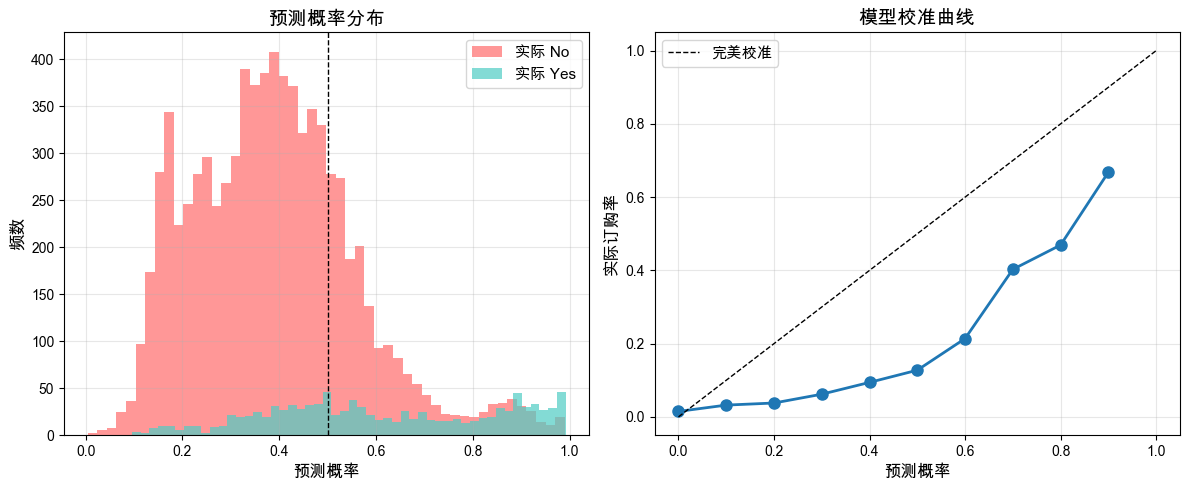

In [25]:
# 使用逻辑回归模型(通常AUC更好)
# 绘制预测概率分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba_lr[y_test == 0], bins=50, alpha=0.7, label='实际 No', color='#FF6B6B')
plt.hist(y_pred_proba_lr[y_test == 1], bins=50, alpha=0.7, label='实际 Yes', color='#4ECDC4')
plt.xlabel('预测概率', fontsize=12)
plt.ylabel('频数', fontsize=12)
plt.title('预测概率分布', fontsize=14)
plt.legend(fontsize=11)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='阈值=0.5')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
proba_bins = np.arange(0, 1.1, 0.1)
proba_binned = np.digitize(y_pred_proba_lr, proba_bins)
actual_rate = [y_test[proba_binned == i].mean() if len(y_test[proba_binned == i]) > 0 else 0 
              for i in range(1, len(proba_bins))]
plt.plot(proba_bins[:-1], actual_rate, marker='o', linewidth=2, markersize=8)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='完美校准')
plt.xlabel('预测概率', fontsize=12)
plt.ylabel('实际订购率', fontsize=12)
plt.title('模型校准曲线', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 9.2 客户细分策略

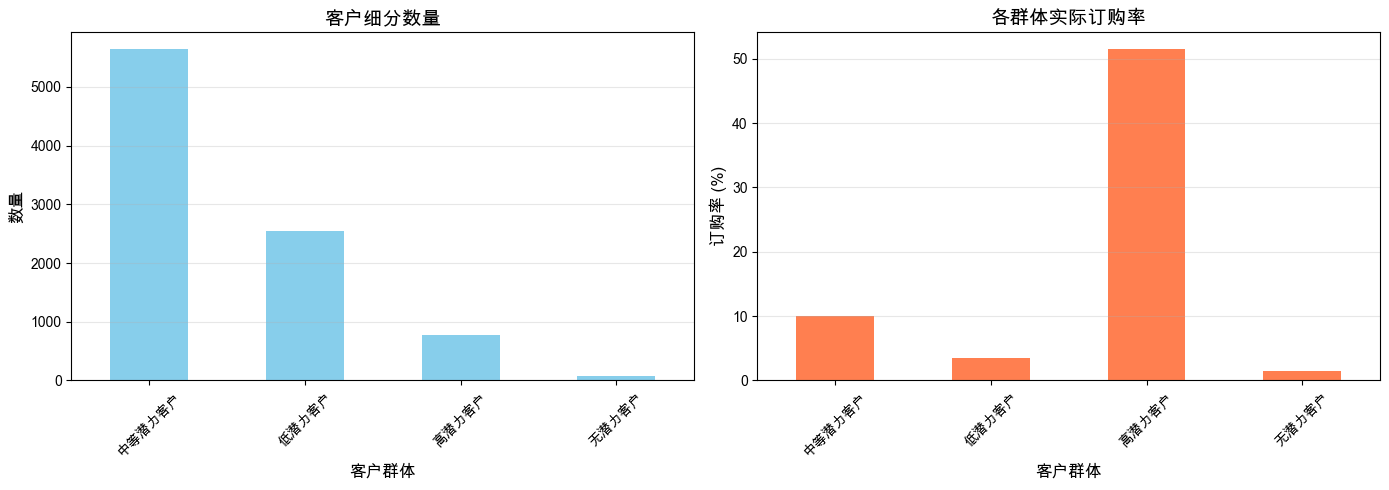


客户细分结果:
中等潜力客户: 5648人 (62.5%), 实际订购率: 10.0%
低潜力客户: 2550人 (28.2%), 实际订购率: 3.5%
高潜力客户: 778人 (8.6%), 实际订购率: 51.5%
无潜力客户: 67人 (0.7%), 实际订购率: 1.5%


In [26]:
# 基于预测概率分组
def categorize_customer(prob):
    if prob > 0.7:
        return '高潜力客户'
    elif prob > 0.3:
        return '中等潜力客户'
    elif prob > 0.1:
        return '低潜力客户'
    else:
        return '无潜力客户'

customer_segments = pd.Series(y_pred_proba_lr).apply(categorize_customer)
segment_counts = customer_segments.value_counts()
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
segment_actual_rate = pd.Series([
    y_test_array[customer_segments == seg].mean()  # ✅ 使用numpy数组
    for seg in segment_counts.index
], index=segment_counts.index)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 客户数量分布
segment_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('客户细分数量', fontsize=14)
axes[0].set_xlabel('客户群体', fontsize=12)
axes[0].set_ylabel('数量', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# 实际订购率
(segment_actual_rate * 100).plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('各群体实际订购率', fontsize=14)
axes[1].set_xlabel('客户群体', fontsize=12)
axes[1].set_ylabel('订购率 (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n客户细分结果:")
for seg in segment_counts.index:
    print(f"{seg}: {segment_counts[seg]}人 ({segment_counts[seg]/len(customer_segments)*100:.1f}%), "
          f"实际订购率: {segment_actual_rate[seg]*100:.1f}%")

### 9.3 营销策略建议

In [27]:
print("\n基于模型的营销策略:")
print("\n1. 高潜力客户 (概率 > 0.7):")
print("   - 优先级: ⭐⭐⭐⭐⭐")
print("   - 策略: 专人服务、提供最优惠利率、快速跟进")
print("   - 预期转化率: 70%+")

print("\n2. 中等潜力客户 (0.3 < 概率 < 0.7):")
print("   - 优先级: ⭐⭐⭐")
print("   - 策略: 标准营销流程、教育产品优势、提供案例")
print("   - 预期转化率: 30-70%")

print("\n3. 低潜力客户 (0.1 < 概率 < 0.3):")
print("   - 优先级: ⭐")
print("   - 策略: 低频次接触、群发邮件、自动化营销")
print("   - 预期转化率: 10-30%")

print("\n4. 无潜力客户 (概率 < 0.1):")
print("   - 优先级: 不联系")
print("   - 策略: 暂不营销,避免骚扰降低品牌形象")
print("   - 预期转化率: <10%")

# ROI估算
print("\n\n营销ROI估算 (假设每通电话成本10元):")
cost_per_call = 10
revenue_per_subscription = 1000  # 假设每个订购带来1000元收益

for seg in segment_counts.index:
    n_customers = segment_counts[seg]
    conversion_rate = segment_actual_rate[seg]
    total_cost = n_customers * cost_per_call
    total_revenue = n_customers * conversion_rate * revenue_per_subscription
    roi = (total_revenue - total_cost) / total_cost * 100
    
    print(f"\n{seg}:")
    print(f"  营销成本: {total_cost:,.0f}元")
    print(f"  预期收益: {total_revenue:,.0f}元")
    print(f"  ROI: {roi:.1f}%")


基于模型的营销策略:

1. 高潜力客户 (概率 > 0.7):
   - 优先级: ⭐⭐⭐⭐⭐
   - 策略: 专人服务、提供最优惠利率、快速跟进
   - 预期转化率: 70%+

2. 中等潜力客户 (0.3 < 概率 < 0.7):
   - 优先级: ⭐⭐⭐
   - 策略: 标准营销流程、教育产品优势、提供案例
   - 预期转化率: 30-70%

3. 低潜力客户 (0.1 < 概率 < 0.3):
   - 优先级: ⭐
   - 策略: 低频次接触、群发邮件、自动化营销
   - 预期转化率: 10-30%

4. 无潜力客户 (概率 < 0.1):
   - 优先级: 不联系
   - 策略: 暂不营销,避免骚扰降低品牌形象
   - 预期转化率: <10%


营销ROI估算 (假设每通电话成本10元):

中等潜力客户:
  营销成本: 56,480元
  预期收益: 566,000元
  ROI: 902.1%

低潜力客户:
  营销成本: 25,500元
  预期收益: 90,000元
  ROI: 252.9%

高潜力客户:
  营销成本: 7,780元
  预期收益: 401,000元
  ROI: 5054.2%

无潜力客户:
  营销成本: 670元
  预期收益: 1,000元
  ROI: 49.3%


## 10. 总结与扩展

### 10.1 项目总结

1. **数据预处理**:
   - 移除了duration特征避免数据泄漏
   - 使用独热编码处理类别特征
   - 使用标准化处理数值特征

2. **模型训练**:
   - 逻辑回归: 简单快速,输出概率,适合线性关系
   - 决策树: 捕捉非线性,自动特征选择,易解释
   - 使用class_weight='balanced'处理类别不平衡

3. **模型评估**:
   - AUC-ROC是最重要的指标(类别不平衡场景)
   - F1分数平衡了精确率和召回率
   - 混淆矩阵帮助理解预测错误类型

4. **业务应用**:
   - 基于预测概率进行客户细分
   - 制定差异化营销策略
   - 估算营销ROI指导决策

### 10.2 扩展方向

1. **特征工程**:
   - 创建交互特征: age×job, balance×housing
   - 时间特征: 季节性(month), 周期性
   - 聚合特征: 历史营销总次数、成功率

2. **模型优化**:
   - 超参数调优: GridSearchCV, RandomSearchCV
   - 集成学习: RandomForest, XGBoost, LightGBM
   - 深度学习: 多层感知机(MLP)

3. **类别不平衡处理**:
   - SMOTE过采样
   - 欠采样 (Random Undersampling)
   - 集成方法 (BalancedBaggingClassifier)

4. **模型解释**:
   - SHAP值: 理解每个特征对预测的贡献
   - LIME: 局部可解释性
   - Partial Dependence Plot: 特征影响可视化

5. **模型部署**:
   - 保存模型: pickle/joblib
   - API服务: Flask/FastAPI
   - 实时预测: 在线学习(Online Learning)
   - 模型监控: 数据漂移检测、性能监控

## 11. 思考题

1. **为什么不能使用duration特征？如果使用会有什么后果？**

2. **在类别不平衡场景下，为什么准确率不是好指标？应该用什么指标？**

3. **逻辑回归和决策树各有什么优缺点？如何选择？**

4. **如果要提高召回率(覆盖更多潜在客户)，应该如何调整模型？**

5. **如何评估模型是否过拟合？如何解决过拟合？**

6. **除了预测是否订购，这个模型还能用于什么业务场景？**

7. **如果模型部署后发现效果变差，可能是什么原因？**

In [28]:
print("\n恭喜完成P03银行营销分类项目！")
print("\n下一步:")
print("- P04: 电信客户流失预测 (RFM + 流失预测)")
print("- P05: 零售超市SWOT分析 (关联规则挖掘)")
print("- P06: 滴滴运营异常检测 (时序分析)")


恭喜完成P03银行营销分类项目！

下一步:
- P04: 电信客户流失预测 (RFM + 流失预测)
- P05: 零售超市SWOT分析 (关联规则挖掘)
- P06: 滴滴运营异常检测 (时序分析)
